The goal of this notebook is to make the `myv` sentence encoder even more compatible with LaBSE than before.

Evaluation criteria:
* average cosine similarity on the validation set (emb(myv) to emb(ru))

In [ ]:
!pip install sentencepiece transformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [ ]:
import torch
import gc
import numpy as np
import matplotlib.pyplot as plt

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
import random
from tqdm.auto import tqdm, trange
import pandas as pd
import os

In [ ]:
mname_base = 'slone/LaBSE-en-ru-myv-v1'
mname_teacher = 'cointegrated/LaBSE-en-ru'
mname_save = '/gd/MyDrive/models/myv/LaBSE-en-ru-myv-v2'

In [ ]:
if os.path.exists(mname_save):
    mname_base = mname_save
    print('loading the model from the temporary checkpoint')

loading the model from the temporary checkpoint


In [ ]:
import torch
from transformers import AutoModelForPreTraining, AutoTokenizer

In [ ]:
print("loading student from", mname_base)

tokenizer_s = AutoTokenizer.from_pretrained(mname_base)
model_s = AutoModelForPreTraining.from_pretrained(mname_base)
if torch.cuda.is_available():
    model_s.cuda()

loading student from /gd/MyDrive/models/myv/LaBSE-en-ru-myv-v2


In [ ]:
tokenizer_t = AutoTokenizer.from_pretrained(mname_teacher)
model_t = AutoModelForPreTraining.from_pretrained(mname_teacher)
if torch.cuda.is_available():
    model_t.cuda()

In [ ]:
from datasets import load_dataset
data_extended = load_dataset(
    'slone/myv_ru_2022',
    data_files={'train':'train.jsonl', 'validation': 'dev.jsonl', 'test': 'test.jsonl', 'mono': 'back_translated.jsonl'}
)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating mono split: 0 examples [00:00, ? examples/s]

In [ ]:
data_extended['train'][0]

{'myv': '! Вадо!/Азёдо тестэ!', 'ru': 'отойти', 'src': ''}

In [ ]:
all_pairs = [(item['myv'], item['ru']) for item in data_extended['train']]

In [ ]:
len(all_pairs)

74503

In [ ]:
all_sentences = sorted(
    {item['myv'] for item in data_extended['train']}.union({item['myv'] for item in data_extended['mono']}).difference({item['myv'] for item in data_extended['validation']}).difference({item['myv'] for item in data_extended['test']})
)

In [ ]:
len(all_sentences)

333651

In [ ]:
random.choice(all_sentences)

'Сон уш эзь пеле сценадонть ды ломантнеде, марясь прянзо эсь таркасо.'

In [ ]:
random.choice(all_pairs)

('пикс килькш', 'аркан')

In [ ]:
from transformers import DataCollatorForWholeWordMask
collator = DataCollatorForWholeWordMask(tokenizer_s, mlm=True, mlm_probability=0.3)

In [ ]:
def get_acc2(e1, e2):
    batch_size = e1.shape[0]
    with torch.no_grad():
        scores = torch.matmul(e1, e2.T).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model_s.parameters() if p.requires_grad],
    scale_parameter=False, relative_step=False,
    lr=5e-6, # make it very slow, because we want to update too many parameters
    clip_threshold=1.0
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 32 # this is the maximum for a 16GB GPU with full precision
mlm_batch_size = batch_size
margin = 0.3

In [ ]:
losses2 = []
accuracies2 = []
losses_mlm = []

In [ ]:
model, tokenizer, teacher_model, teacher_tokenizer = model_s, tokenizer_s, model_t, tokenizer_t

In [ ]:
model_s.train()

tq = trange(300_000)
for i in tq:
    myv, ru = [list(p) for p in zip(*random.choices(all_pairs, k=batch_size))]
    try:
        # translation ranking step step
        # in this setup, we always want to pull only to the teacher model, because it is the "ground truth".
        tm, tt = (teacher_model.bert, teacher_tokenizer) # if random.random() < 0.8 else (model.bert, tokenizer)
        ru_batch = tt(ru, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            ru_emb = torch.nn.functional.normalize(tm(**ru_batch.to(teacher_model.device)).pooler_output)

        myv_batch = tokenizer(myv, return_tensors='pt', padding=True, truncation=True, max_length=128)
        myv_emb = torch.nn.functional.normalize(model.bert(**myv_batch.to(model.device)).pooler_output)
        all_scores = torch.matmul(ru_emb, myv_emb.T) - torch.eye(batch_size, device=model.device) * margin
        loss = loss_fn(all_scores, torch.arange(batch_size, device=model.device)) + loss_fn(all_scores.T, torch.arange(batch_size, device=model.device))
        loss.backward()
        losses2.append(loss.item())
        accuracies2.append(get_acc2(myv_emb, ru_emb))

        # mlm step
        sents = random.choices(all_sentences, k=mlm_batch_size)
        myv_batch = {k: v.to(model.device) for k, v in collator([tokenizer(s) for s in sents]).items()}
        loss = loss_fn(
            model(**myv_batch).prediction_logits.view(-1, model.config.vocab_size),
            myv_batch['labels'].view(-1)
        )
        loss.backward()
        losses_mlm.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in myv + ru))
        continue
    if i % 100 == 0:
        print(i, np.mean(losses2[-100:]), np.mean(accuracies2[-100:]), np.mean(losses_mlm[-100:]))
    if i % 1000 == 0 and i > 0:
        model.save_pretrained(mname_save)
        tokenizer.save_pretrained(mname_save)

  0%|          | 0/300000 [00:00<?, ?it/s]

0 6.318752779960632 0.908125 4.454427351951599
error 134
100 6.319189419746399 0.9103125 4.409783272743225
200 6.314705219268799 0.9034375 4.450067644119263
300 6.31298894405365 0.9125 4.551759350299835
400 6.319888129234314 0.9075 4.427070219516754
error 318
500 6.317595806121826 0.9075 4.493810172080994
600 6.319932990074157 0.89859375 4.395219767093659
700 6.307612161636353 0.9096875 4.455476336479187
800 6.3173803615570066 0.9025 4.414918541908264
900 6.314767303466797 0.9046875 4.389991571903229
1000 6.319034543037414 0.91046875 4.424154057502746
error 239
1100 6.3122245931625365 0.90828125 4.45274313211441
1200 6.3153755617141725 0.9115625 4.387089307308197
error 232
1300 6.3179836845397945 0.904375 4.417143864631653
1400 6.324012966156006 0.8978125 4.415846519470215
1500 6.31223687171936 0.9075 4.451747353076935
1600 6.319018096923828 0.9015625 4.377170701026916
1700 6.309712700843811 0.9059375 4.443418970108032
1800 6.3245463180542 0.90015625 4.388111979961395
1900 6.3201779890

62771


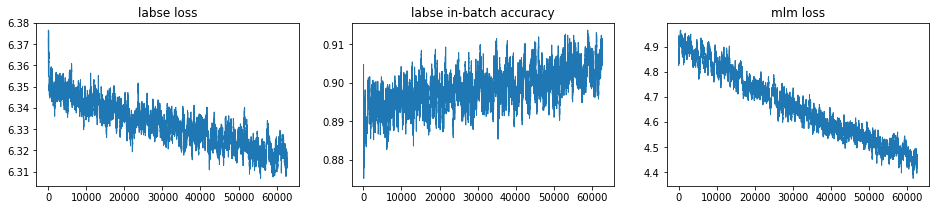

In [ ]:
print(len(losses2))
plt.figure(figsize=(16, 3))
names = ['labse loss', 'labse in-batch accuracy', 'mlm loss']
for i, s in enumerate([losses2, accuracies2, losses_mlm]):
    plt.subplot(1, 3, i+1)
    pd.Series(s).ewm(100).mean()[10:].plot(lw=1)
    plt.title(names[i])

Start: metrics are about 6.41, 0.87, 5.3

Run 1, 29774 + 38000 steps, (lr=2e-6, batch=32): metrics are 6.348492040634155 0.8859375 4.897445335388183

Run2, 62771 + 28500 steps, metrics are 6.308381876945496 0.91515625 4.321424610614777

# Evaluation

| model | mean sim | acc (ru<-myv) | acc (myv<-ru)|
|-|-|-|-|
| Teacher wrt self | 0.413534 | 0.4033333333333333 | 0.458 |
| Baseline (wrt teacher)  | 0.621234 |  0.92 | 0.9053333333333333 |
| Baseline (wrt self)  |  0.842680 |  0.9213333333333333 | 0.9093333333333333 |
|Epoch 1 (wrt teacher) | 0.678271 | 0.922 | 0.9113333333333333 |
|Epoch 1 (wrt self)    | 0.8342987 | 0.9293333333333333 | 0.9146666666666666 |
|Epoch 2 (wrt teacher) | 0.6844518 | 0.9266666666666666 | 0.914 |
|Epoch 2 (wrt self)    | 0.8389487 | 0.9326666666666666 | 0.9153333333333333 |


After 2 epochs, the quality seems to be almost saturated. Maybe, we are overfitting the training data, or we are overfitting the model for the MLM task (the last is not bad).

In [ ]:
model_s.eval();

In [ ]:
def embed(texts, model, tokenizer, batch_size=32):
    result = []
    for i in trange(0, len(texts), batch_size):
        batch = tokenizer(texts[i:i+batch_size], return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.inference_mode():
            emb = torch.nn.functional.normalize(model.bert(**batch.to(model.device)).pooler_output).cpu().numpy()
        result.append(emb)
    return np.concatenate(result)

In [ ]:
teacher_emb_ru = embed(data_extended['validation']['ru'], model_t, tokenizer_t)

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
emb_myv = embed(data_extended['validation']['myv'], model_s, tokenizer_s)

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
print((teacher_emb_ru * emb_myv).sum(1).mean())  # 0.6844518
sims = np.matmul(teacher_emb_ru, emb_myv.T)

print((sims.argmax(1) == np.arange(sims.shape[0])).mean()) # 0.9266666666666666
print((sims.argmax(0) == np.arange(sims.shape[0])).mean())  # 0.914

0.62123454
0.92
0.9053333333333333


In [ ]:
emb_ru = embed(data_extended['validation']['ru'], model_s, tokenizer_s)

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
print((emb_ru * emb_myv).sum(1).mean())  # 0.8389487
sims = np.matmul(emb_ru, emb_myv.T)

print((sims.argmax(1) == np.arange(sims.shape[0])).mean())  # 0.9326666666666666
print((sims.argmax(0) == np.arange(sims.shape[0])).mean())  # 0.9153333333333333

0.8426807
0.9213333333333333
0.9093333333333333


In [ ]:
teacher_emb_myv = embed(data_extended['validation']['myv'], model_t, tokenizer_t)

In [ ]:
print((teacher_emb_ru * teacher_emb_myv).sum(1).mean())
sims = np.matmul(teacher_emb_ru, teacher_emb_myv.T)

print((sims.argmax(1) == np.arange(sims.shape[0])).mean())
print((sims.argmax(0) == np.arange(sims.shape[0])).mean())

0.41353443
0.4033333333333333
0.458


In [ ]:
student_emb_ru = embed(data_extended['validation']['ru'], model_s, tokenizer_s)
student_emb_myv = embed(data_extended['validation']['myv'], model_s, tokenizer_s)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
print((student_emb_ru * student_emb_myv).sum(1).mean())
sims = np.matmul(student_emb_ru, student_emb_myv.T)

print((sims.argmax(1) == np.arange(sims.shape[0])).mean())
print((sims.argmax(0) == np.arange(sims.shape[0])).mean())

0.8426807
0.9213333333333333
0.9093333333333333


# MLM evaluation


* After 2 epochs, filler recall at 1 / at 5 is 0.1869 / 0.3406
* Before continued training, it was 0.1074 / 0.2183

So MLM seems to really benefit from this training, even if sentence encoding does not!

In [ ]:
import re
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained(mname_save).cuda();
#model = AutoModelForMaskedLM.from_pretrained('slone/LaBSE-en-ru-myv-v1').cuda();


Some weights of the model checkpoint at /gd/MyDrive/models/myv/LaBSE-en-ru-myv-v2 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import pipeline
filler = pipeline("fill-mask", model=model, tokenizer=tokenizer_s, device=model_s.device)

In [ ]:
random.seed(1)
sample = random.sample(data_extended['validation']['myv'], 100)
sample[:5]

['Вармась пуви-ливти лембе ёнксов, велявты – пувазеви якшамо ёнксов, пувамстонзо вели-чары, вели-чары ды одов велявты кеверь кинзэ лангс.',
 'Алекса́ндр Гре́йам Белл (англ. Alexander Graham Bell;',
 'Сон максызе Эсь прянзо минек пежетнень кисэ: истя идемс минек те неень зыянов шканть эйстэ. Теньсэ Сон топавтызе минек Тетя Пазонть мелензэ.',
 'XII ГЛАВАГерб, флаг, столица',
 'Иисус, кода неизе аванзо ды вакссонзо аштиця тонавтницянзо, конань Сон вечкилизе, мерсь аванстэнь: «Авай, те ней тонь цёрат».']

In [ ]:
hits = []
hits5 = []
for text in tqdm(sample):
    for match in list(re.finditer(r'\b\w+\b', text)):
        b, e = match.span()
        x = text[:b] + '[MASK]' + text[e:]
        y = text[b:e]
        hyps = filler(x)
        hits.append(y == hyps[0]['token_str'])
        hits5.append(y in {h['token_str'] for h in hyps})
print(np.mean(hits))
print(np.mean(hits5))

  0%|          | 0/100 [00:00<?, ?it/s]

0.1868995633187773
0.3406113537117904


# Pushing

In [ ]:
import huggingface_hub
huggingface_hub.login()

In [ ]:
model_s.push_to_hub("slone/LaBSE-en-ru-myv-v2")

pytorch_model.bin:   0%|          | 0.00/575M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/slone/LaBSE-en-ru-myv-v2/commit/6c561456c74f33f4eb3baa2718cb8fb059ceaedc', commit_message='Upload BertForPreTraining', commit_description='', oid='6c561456c74f33f4eb3baa2718cb8fb059ceaedc', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer_s.push_to_hub("slone/LaBSE-en-ru-myv-v2")

CommitInfo(commit_url='https://huggingface.co/slone/LaBSE-en-ru-myv-v2/commit/579502972c67265a3d138f1bed0e6eb672a5c39b', commit_message='Upload tokenizer', commit_description='', oid='579502972c67265a3d138f1bed0e6eb672a5c39b', pr_url=None, pr_revision=None, pr_num=None)

# As sentence transformer

In [41]:
import numpy as np

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

In [25]:
tokenizer = AutoTokenizer.from_pretrained("slone/LaBSE-en-ru-myv-v2")

In [19]:
base_model = AutoModel.from_pretrained("slone/LaBSE-en-ru-myv-v2")
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(74181, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [2]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses

In [6]:
import sentence_transformers

In [7]:
labse = sentence_transformers.SentenceTransformer('sentence-transformers/LaBSE')

In [8]:
labse

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [3]:
block1 = models.Transformer("slone/LaBSE-en-ru-myv-v2")

In [10]:
block2 = models.Pooling(
    block1.get_word_embedding_dimension(), 'cls'
)

In [14]:
block2

Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})

In [21]:
p = base_model.pooler
p

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [32]:
block3 = models.Dense(
    in_features=p.dense.in_features,
    out_features=p.dense.out_features,
    init_weight=p.dense.weight.data,
    init_bias=p.dense.bias.data,
)
block3

Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})

In [33]:
block4 = models.Normalize()

In [34]:
stf = SentenceTransformer(modules=[block1, block2, block3, block4])

In [27]:
text = 'покш сюкпря'

In [29]:
def old_embed(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = base_model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.numpy()

In [30]:
emb1 = old_embed(text)

In [35]:
emb2 = stf.encode(text)

In [42]:
np.abs(emb1 - emb2).max()

8.381903e-08

In [44]:
!git clone https://huggingface.co/slone/LaBSE-en-ru-myv-v2

Cloning into 'LaBSE-en-ru-myv-v2'...


In [45]:
stf.save('LaBSE-en-ru-myv-v2')

In [66]:
# now I manually delete what I don't need, and commit the rest

In [57]:
!cd LaBSE-en-ru-myv-v2 && git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   1_Pooling/config.json
	new file:   2_Dense/config.json
	new file:   2_Dense/pytorch_model.bin
	new file:   modules.json
	new file:   sentence_bert_config.json

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.idea/
	config_sentence_transformers.json



In [50]:
!cd LaBSE-en-ru-myv-v2 && git checkout pytorch_model.bin && git checkout README.md && git checkout config.json

Updated 1 path from the index
Updated 1 path from the index
Updated 1 path from the index


In [53]:
!cd LaBSE-en-ru-myv-v2 && git checkout special_tokens_map.json && git checkout tokenizer.json && git checkout vocab.txt

Updated 1 path from the index
Updated 1 path from the index
Updated 1 path from the index


In [56]:
!cd LaBSE-en-ru-myv-v2 && git add 1_Pooling && git add 2_Dense && git add modules.json && git add sentence_bert_config.json

In [60]:
!cd LaBSE-en-ru-myv-v2 && git commit -m "add sentence transformers wrapper"

[main d300fbd] add sentence transformers wrapper
 5 files changed, 41 insertions(+)
 create mode 100644 1_Pooling/config.json
 create mode 100644 2_Dense/config.json
 create mode 100644 2_Dense/pytorch_model.bin
 create mode 100644 modules.json
 create mode 100644 sentence_bert_config.json


In [61]:
!cd LaBSE-en-ru-myv-v2 && git push

Uploading LFS objects: 100% (1/1), 2.4 MB | 0 B/s, done.


To https://huggingface.co/slone/LaBSE-en-ru-myv-v2
   f7483ec..d300fbd  main -> main


In [65]:
# !rmdir LaBSE-en-ru-myv-v2